<a href="https://colab.research.google.com/github/Intelecy/covid-19-research/blob/areeh/COVID_19_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 model using a Bayesian time series model ()

In [0]:
#@title Install non-standard libraries
!pip install -q pycountry

In [0]:
#@title Imports
import contextlib
import datetime
from fbprophet import Prophet
from google.colab import files
import io
import logging
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
import pandas as pd 
import pdb
import plotly
import plotly.graph_objects as go
import pycountry
import pymc3 as pm
# print('Running on PyMC3 v{}'.format(pm.__version__))
from IPython.utils import io as ipython_io
import seaborn as sns
import time

## Import data

In [0]:
#@title Load the raw death data from the ecdc website if is not loaded yet
# Data sources:
# Full data (current): !wget https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-19.xlsx
# Incomplete data:
#     Deaths: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#     Confirmed: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
if 'daily_df' not in locals():
  yesterday_str = (datetime.date.today() - datetime.timedelta(days=1)).strftime(
      '%Y-%m-%d')
  today_str = datetime.date.today().strftime('%Y-%m-%d')
  # !wget https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-19.xlsx
  !wget https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{yesterday_str}.xlsx
  !wget https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{today_str}.xlsx
  try:
    daily_df = pd.read_excel("COVID-19-geographic-disbtribution-worldwide-" + today_str + ".xlsx")
    data_str = today_str
  except:
    daily_df = pd.read_excel("COVID-19-geographic-disbtribution-worldwide-" + yesterday_str + ".xlsx")
    data_str = yesterday_str
  # confirmed_df = pd.read_csv(io.BytesIO(uploaded['time_series_19-covid-Deaths.csv']))
  # deaths_df = pd.read_csv(io.BytesIO(uploaded['time_series_19-covid-Deaths.csv']))
# Population Data:
#     https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx

if 'pop_df' not in locals():
  !wget "https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx"
  pop_cols = ['Index', 'Region, subregion, country or area *', 'Country code', 'Type', '2020']
  pop_df = pd.read_excel("WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx", header=16, index_col=0, usecols=pop_cols)
  pop_df = pop_df[pop_df['Type'] != 'Label/Separator']
  pop_df = pop_df.astype({'Country code': 'int32', '2020': 'int32'})

In [0]:
#@title Population lookup helper function
def get_pop(row):
  geo_id = row["GeoId"]
  if geo_id == "UK":
    geo_id = "GB"
  try:
    country_code = int(pycountry.countries.get(alpha_2=geo_id).numeric)
    pop = pop_df[pop_df['Country code'] == country_code].iloc[0]['2020'] * 1000
    return pop
  except AttributeError:
    return float("nan")

In [0]:
#@title Inspect the first rows to verify the data was loaded correctly
daily_df.head()

## Preprocessing

1. Drop countries/regions with limited or no confirmed to date
1. Drop redundant columns
1. Drop regions that don't report the full period of Dec 31 up until now

In [0]:
min_confirmed = 1000 #@param {type:"integer"}
min_deaths = 2 #@param {type:"integer"}

daily_df['Date'] = daily_df['DateRep'].copy().astype(str)
pd.to_datetime(daily_df['DateRep'], format='%Y-%m-%d')
min_date = daily_df.DateRep.values.min()
max_date = daily_df.DateRep.values.max()

total_counts = daily_df.groupby(['GeoId']).sum()[["Cases", "Deaths"]]
current_total_confirmed = total_counts.Cases.values
current_total_deaths = total_counts.Deaths.values

# Get geo ids that contain sufficient data for modeling
analysis_geo_ids = total_counts.index.values[np.where(np.logical_and(
    current_total_confirmed >= min_confirmed,
    current_total_deaths >= min_deaths))[0]]

# Drop countries where the initial reported data is not the first date or where
# the last reported data is not the last date
analysis_df = daily_df[daily_df['GeoId'].isin(analysis_geo_ids)]
not_first = analysis_geo_ids[analysis_df.groupby(
    ['GeoId']).min().DateRep > min_date]
not_last = analysis_geo_ids[analysis_df.groupby(
    ['GeoId']).max().DateRep < max_date]
print("Dropped not first date geo ids: {}".format(not_first))
print("Dropped not last date geo ids: {}".format(not_last))
analysis_geo_ids = np.setdiff1d(analysis_geo_ids, not_first)
analysis_geo_ids = np.setdiff1d(analysis_geo_ids, not_last)

country_col_name = "Countries and territories"
analysis_df = analysis_df[analysis_df['GeoId'].isin(analysis_geo_ids)][
  ["Date", "DateRep", "Cases", "Deaths", "GeoId", country_col_name]]

# Drop countries with gaps in the reported data
reporting_counts = analysis_df['GeoId'].value_counts()
num_days = reporting_counts.max()
analysis_geo_ids = reporting_counts.index.values[np.where(
    reporting_counts == num_days)[0]]
analysis_df = analysis_df[analysis_df['GeoId'].isin(analysis_geo_ids)]
analysis_df = analysis_df.iloc[::-1]

num_countries = analysis_geo_ids.size
print("Num analysed countries: {}".format(num_countries))
print("Analysed geo ids: {}".format(analysis_geo_ids))
analysis_countries = np.sort(np.unique(analysis_df[[country_col_name]].values))
print("Analysed countries: {}".format(analysis_countries))
analysis_df.index = np.arange(analysis_df.shape[0])

# Add model features (days since start)
analysis_df['days_since_start'] = np.tile(np.arange(num_days), num_countries)
analysis_df['country_id'] = np.repeat(np.arange(num_countries), num_days)

# Add population data
analysis_df["Population"] = analysis_df.apply(lambda row: get_pop(row), axis=1)
analysis_df["Deaths_pc"] = analysis_df["Deaths"] / analysis_df["Population"]
analysis_df["Cases_pc"] = analysis_df["Cases"] / analysis_df["Population"]

In [0]:
#@title Possibly override the data with John Hopkins data
override_john_hopkins_data = True #@param ["False", "True"] {type:"raw"}

if override_john_hopkins_data:
  !rm time_series_covid19_confirmed_global.csv
  !rm time_series_covid19_deaths_global.csv
  !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
  !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv

  jh_confirmed = pd.read_csv("time_series_covid19_confirmed_global.csv")
  jh_deaths = pd.read_csv("time_series_covid19_deaths_global.csv")
  
  jh_confirmed = jh_confirmed.groupby(['Country/Region']).sum()
  jh_deaths = jh_deaths.groupby(['Country/Region']).sum()

  country_map = {"South Korea": "Korea, South", "United States Of America": "US"}
  analysis_df[country_col_name] = analysis_df[country_col_name].str.replace("_", " ").str.title()
  for country in np.sort(np.unique(analysis_df[country_col_name].values)):
    jh_country = country_map.get(country, country)
    if country == "China":
      print("Don't use JH for China")
    elif jh_country in jh_confirmed.index:
      jh_confirmed_c = jh_confirmed.iloc[np.where(jh_confirmed.index == jh_country)[0][0], 2:].values
      jh_deaths_c = jh_deaths.iloc[np.where(jh_confirmed.index == jh_country)[0][0], 2:].values
      jh_confirmed_day = np.diff(np.concatenate([np.array([0]), jh_confirmed_c]))
      jh_deaths_day = np.diff(np.concatenate([np.array([0]), jh_deaths_c]))
      country_index = np.where(analysis_df[country_col_name].values == country)[0][0]
      for i in np.arange(jh_confirmed_day.size):
        index = country_index + i + 22 # First day of reporting Jan 22 as Opposed to 31 Dec (22 days offset)
        analysis_df.loc[index, "Cases"] = jh_confirmed_day[i]
        analysis_df.loc[index, "Deaths"] = jh_deaths_day[i]
    else:
      print("Name non match: {}".format(country))

  # Drop the data of today if the John Hopkins data is not available yet
  last_jh_day = jh_deaths.columns.values[-1]
  last_jh_datetime = datetime.datetime.strptime(last_jh_day, '%m/%d/%y')
  
  if last_jh_datetime != datetime.datetime.strptime(data_str, '%Y-%m-%d'):
    analysis_df = analysis_df.iloc[analysis_df.Date.values != analysis_df.Date.max()]
    num_days -= 1
    analysis_df.index = np.arange(analysis_df.shape[0])

# Drop data of the last day if all counts are zero
last_day = analysis_df.Date.max()
second_last_day = np.sort(np.unique(analysis_df.Date.values))[-2]
if analysis_df.Deaths.values[analysis_df.Date == last_day].sum() < (
    analysis_df.Deaths.values[analysis_df.Date == second_last_day].sum())/4:
  analysis_df = analysis_df.iloc[analysis_df.Date.values != last_day]
  num_days -= 1
  analysis_df.index = np.arange(analysis_df.shape[0])

# Norway specific override
norway_index = np.where(analysis_df[country_col_name].values == "Norway")[0][0]
analysis_df.loc[norway_index + 72, "Deaths"] = 1
analysis_df.loc[norway_index + 74, "Deaths"] = 2

analysis_df["Deaths_pc"] = analysis_df["Deaths"] / analysis_df["Population"]
analysis_df["Cases_pc"] = analysis_df["Cases"] / analysis_df["Population"]

## Helpers

In [0]:
#@title Find first greater than helper function
@jit(nopython=True)
def find_first_greater_than(value, vec) -> int:
    """return the index of the first occurrence greater than value in vec"""
    for i in range(len(vec)):
        if vec[i] > value:
            return i
    return -1

In [0]:
#@title Sorted by start date plot tuples helper
from typing import NamedTuple, List
from operator import attrgetter

class PlotTuple(NamedTuple):
  geo_id: str
  start_idx: int
  start_ts: pd.Timestamp

def create_sorted_plot_tuples(
    geo_ids: np.ndarray,
    df: pd.DataFrame,
    start_value: int,
    start_col: str
) -> List[PlotTuple]:
  plot_tuple_lst = []
  for i, geo_id in enumerate(analysis_geo_ids):
    country_df = analysis_df[analysis_df.GeoId.values == geo_id]
    start_col_values = analysis_df[start_col].values[analysis_df.GeoId.values == geo_id]
    start_col_values = np.cumsum(start_col_values)
    start_idx = find_first_greater_than(start_value, start_col_values)

    if start_idx == -1:
      country = analysis_df[country_col_name].values[analysis_df.GeoId.values == geo_id][0]
      print(
          f"{country} did not have more than {start_value} cumulative {start_col}. "
            "Dropping from plot."
      )
    else:
      start_date = country_df.iloc[start_idx].Date
      start_date = pd.Timestamp(start_date)
    
      plot_tuple = PlotTuple(geo_id=geo_id, start_idx=start_idx, start_ts=start_date)
      plot_tuple_lst.append(plot_tuple)

  plot_tuple_lst = sorted(plot_tuple_lst, key=attrgetter("start_ts"))
  return plot_tuple_lst




In [0]:
#@title trace color helper
def get_color(i: int) -> str:
  cat_col = sns.color_palette()[i % 10]
  rgb_cols = [str(int(v*256)) for v in list(cat_col)]
  marker_color = 'rgb(' + ', '.join(rgb_cols) + ')'
  return marker_color

In [0]:
#@title create hoverdata helper
from typing import Sequence, Tuple, Any
def create_hoverdata(x: Sequence, y: Sequence) -> List[Tuple[Any, int]]:
  hoverdata = list(zip(x, y))
  return hoverdata

In [0]:
#@tile hover template formatters
from functools import partial

HOVER_TEMPLATE_DATE = "%{text|%b %d}"
hover_template = partial("({x}, {y})".format, x=HOVER_TEMPLATE_DATE)
hover_template_int = hover_template(y="%{y:.d}")
hover_template_float = hover_template(y="%{y:.4f}")

## EDA


In [0]:
#@title Confirmed daily cases plot
axis_label_font_size = 20 #@param {type:"integer"}
tick_font_size = 14 #@param {type:"integer"}

fig = go.Figure()
for i, geo_id in enumerate(analysis_geo_ids):
  cat_col = sns.color_palette()[i % 10]
  rgb_cols = [str(int(v*256)) for v in list(cat_col)]
  marker_color = 'rgb(' + ', '.join(rgb_cols) + ')'
  # pdb.set_trace()
  country = analysis_df[country_col_name].values[(
      analysis_df.GeoId.values == geo_id)][0]
  subset_ids = analysis_df.GeoId.values == geo_id
  fig.add_trace(go.Scatter(
      x=analysis_df.Date.values[subset_ids],
      y=analysis_df.Cases.values[subset_ids],
      name=country,
      mode='lines',
      marker_color=marker_color
  ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text='Date', font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text='Daily confirmed cases',
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

def save_plot(fig, plot_name):
  plotly.offline.plot(fig, filename='plots/' + plot_name)

! rm -R plots/
! mkdir plots
save_plot(fig, 'confirmed_daily_raw.html')

In [0]:
#@title Daily deaths plot
fig = go.Figure()
for i, geo_id in enumerate(analysis_geo_ids):
  cat_col = sns.color_palette()[i % 10]
  rgb_cols = [str(int(v*256)) for v in list(cat_col)]
  marker_color = 'rgb(' + ', '.join(rgb_cols) + ')'
  country = analysis_df[country_col_name].values[(
      analysis_df.GeoId.values == geo_id)][0]
  subset_ids = analysis_df.GeoId.values == geo_id
  fig.add_trace(go.Scatter(
      x=analysis_df.Date.values[subset_ids],
      y=analysis_df.Deaths.values[subset_ids],
      name=country,
      mode='lines',
      marker_color=marker_color
  ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text='Date', font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text='Daily deaths',
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))

fig.show()

save_plot(fig, 'deaths_daily_raw.html')

In [0]:
#@title Confirmed daily cases since first deaths plot
from operator import itemgetter, methodcaller

start_deaths =  10#@param {type:"number"}
fig = go.Figure()

plot_tuple_lst = create_sorted_plot_tuples(
    geo_ids=analysis_geo_ids,
    df=analysis_df,
    start_value=start_deaths,
    start_col="Deaths",    
)


for i, plt_tup in enumerate(plot_tuple_lst):
  geo_id = plt_tup.geo_id
  start_idx = plt_tup.start_idx
  start_ts = plt_tup.start_ts
  marker_color = get_color(i)
  current_df = analysis_df[analysis_df.GeoId.values == geo_id]
  country = current_df[country_col_name].iloc[0]
  current_df = current_df.iloc[start_idx:]
  datetimes = current_df.Date.values
  datetimes = [pd.Timestamp(date) for date in datetimes]
  cases = current_df.Cases.values

  fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=cases,
      name=f"{country} start: {start_ts.date()}",
      text=datetimes,
      hovertemplate=hover_template_int,
      mode='lines',
      marker_color=marker_color
  ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since first {start_deaths} death(s)",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Daily confirmed cases",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'confirmed_daily_since_first_deaths.html')

In [0]:
#@title Daily deaths since first deaths plot
start_deaths = 10 #@param {type:"number"}
fig = go.Figure()

plot_tuple_lst = create_sorted_plot_tuples(
    geo_ids=analysis_geo_ids,
    df=analysis_df,
    start_value=start_deaths,
    start_col="Deaths",    
)

for i, plt_tup in enumerate(plot_tuple_lst):
  geo_id = plt_tup.geo_id
  start_idx = plt_tup.start_idx
  start_ts = plt_tup.start_ts
  marker_color = get_color(i)
  current_df = analysis_df[analysis_df.GeoId.values == geo_id]
  country = current_df[country_col_name].iloc[0]
  current_df = current_df.iloc[start_idx:]
  datetimes = current_df.Date.values
  datetimes = [pd.Timestamp(date) for date in datetimes]
  deaths = current_df.Deaths.values

  fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=deaths,
      name=f"{country} start: {start_ts.date()}",
      text=datetimes,
      hovertemplate=hover_template_int,
      mode='lines',
      marker_color=marker_color
  ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since first {start_deaths} death(s)",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Daily deaths",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'deaths_daily_since_first_deaths.html')

In [0]:
#@title Cumulative cases since first deaths plot
start_deaths =  10#@param {type:"number"}
fig = go.Figure()

plot_tuple_lst = create_sorted_plot_tuples(
    geo_ids=analysis_geo_ids,
    df=analysis_df,
    start_value=start_deaths,
    start_col="Deaths",    
)

for i, plt_tup in enumerate(plot_tuple_lst):
  geo_id = plt_tup.geo_id
  start_idx = plt_tup.start_idx
  start_ts = plt_tup.start_ts
  marker_color = get_color(i)
  current_df = analysis_df[analysis_df.GeoId.values == geo_id]
  country = current_df[country_col_name].iloc[0]
  current_df = current_df.iloc[start_idx:]
  datetimes = current_df.Date.values
  datetimes = [pd.Timestamp(date) for date in datetimes]
  cases = current_df.Cases.values

  cases = np.cumsum(cases)

  fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=cases,
      name=f"{country} start: {start_ts.date()}",
      text=datetimes,
      hovertemplate=hover_template_int,
      mode='lines',
      marker_color=marker_color
  ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since first {start_deaths} death(s)",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Cumulative confirmed cases",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'confirmed_cumulative_since_first_deaths.html')

In [0]:
#@title Cumulative deaths since first deaths plot
start_deaths = 10 #@param {type:"number"}
fig = go.Figure()

plot_tuple_lst = create_sorted_plot_tuples(
    geo_ids=analysis_geo_ids,
    df=analysis_df,
    start_value=start_deaths,
    start_col="Deaths",    
)

for i, plt_tup in enumerate(plot_tuple_lst):
  geo_id = plt_tup.geo_id
  start_idx = plt_tup.start_idx
  start_ts = plt_tup.start_ts
  marker_color = get_color(i)
  current_df = analysis_df[analysis_df.GeoId.values == geo_id]
  country = current_df[country_col_name].iloc[0]
  current_df = current_df.iloc[start_idx:]
  deaths = current_df.Deaths.values
  datetimes = current_df.Date.values
  datetimes = [pd.Timestamp(date) for date in datetimes]

  deaths = np.cumsum(deaths)

  fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=deaths,
      name=f"{country} start: {start_ts.date()}",
      text=datetimes,
      hovertemplate=hover_template_int,
      mode='lines',
      marker_color=marker_color
  ))


fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since first {start_deaths} death(s)",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Cumulative deaths",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'deaths_cumulative_since_first_deaths.html')

Norway did not have more than 10 cumulative Deaths. Dropping from plot.
Australia did not have more than 10 cumulative Deaths. Dropping from plot.


In [0]:
#@title Cumulative death/confirmed case ratio since first deaths plot
start_deaths =  10#@param {type:"number"}
fig = go.Figure()

plot_tuple_lst = create_sorted_plot_tuples(
    geo_ids=analysis_geo_ids,
    df=analysis_df,
    start_value=start_deaths,
    start_col="Deaths",    
)

for i, plt_tup in enumerate(plot_tuple_lst):
  geo_id = plt_tup.geo_id
  start_idx = plt_tup.start_idx
  start_ts = plt_tup.start_ts
  marker_color = get_color(i)
  current_df = analysis_df[analysis_df.GeoId.values == geo_id]
  country = current_df[country_col_name].iloc[0]
  current_df = current_df.iloc[start_idx:]
  datetimes = current_df.Date.values
  datetimes = [pd.Timestamp(date) for date in datetimes]
  deaths = current_df.Deaths.values
  cases = current_df.Cases.values

  cum_cases = np.cumsum(cases)
  cum_deaths = np.cumsum(deaths)

  ratio = cum_deaths / cum_cases

  fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=ratio,
      name=f"{country} start: {start_ts.date()}",
      text=datetimes,
      hovertemplate=hover_template_float,
      mode='lines',
      marker_color=marker_color
  ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since first {start_deaths} death(s)",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Cumulative death/confirmed case ratio",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'deaths_case_ratio_cumulative_since_first_deaths.html')

Norway did not have more than 10 cumulative Deaths. Dropping from plot.
Australia did not have more than 10 cumulative Deaths. Dropping from plot.


## EDA (population relative)


In [0]:
#@title Confirmed cumulative cases per capita since critical mass
start_cases = 1  #@param {type:"number"}
fig = go.Figure()
for i, geo_id in enumerate(analysis_geo_ids):
  cat_col = sns.color_palette()[i % 10]
  rgb_cols = [str(int(v*256)) for v in list(cat_col)]
  marker_color = 'rgb(' + ', '.join(rgb_cols) + ')'
  country = analysis_df[country_col_name].values[analysis_df.GeoId.values == geo_id][0]
  cum_cases = np.cumsum(analysis_df.Cases.values[analysis_df.GeoId.values == geo_id])
  cum_cases_pc = cum_cases / analysis_df.Population.values[analysis_df.GeoId.values == geo_id]
  cum_cases_pc *= 100000
  start_idx = find_first_greater_than(start_cases, cum_cases_pc)
  if start_idx > 0:
    fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=cum_cases_pc[start_idx:],
      name=country,
      mode='lines',
      marker_color=marker_color
    ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since reaching > {start_cases} confirmed case(s) per 100K people",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Confirmed cases per 100K people",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'confirmed_normalized_cumulative_since_first_confirmed.html')

In [0]:
#@title Cumulative deaths per capita since critical mass
start_deaths = 0.1 #@param {type:"number"}
fig = go.Figure()
for i, geo_id in enumerate(analysis_geo_ids):
  cat_col = sns.color_palette()[i % 10]
  rgb_cols = [str(int(v*256)) for v in list(cat_col)]
  marker_color = 'rgb(' + ', '.join(rgb_cols) + ')'
  country = analysis_df[country_col_name].values[analysis_df.GeoId.values == geo_id][0]
  cum_deaths = np.cumsum(analysis_df.Deaths.values[analysis_df.GeoId.values == geo_id])
  cum_deaths_pc = cum_deaths / analysis_df.Population.values[analysis_df.GeoId.values == geo_id]
  cum_deaths_pc *= 100000
  start_idx = find_first_greater_than(start_deaths, cum_deaths_pc)
  if start_idx > 0:
    fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=cum_deaths_pc[start_idx:],
      name=country,
      mode='lines',
      marker_color=marker_color
    ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since reaching > {start_cases} confirmed case(s) per 100K people",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Cumulative deaths per 100K people",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'deaths_normalized_cumulative_since_first_confirmed.html')

In [0]:
#@title Confirmed cases per capita since critical mass
start_cases = 1 #@param {type:"number"}
fig = go.Figure()
for i, geo_id in enumerate(analysis_geo_ids):
  cat_col = sns.color_palette()[i % 10]
  rgb_cols = [str(int(v*256)) for v in list(cat_col)]
  marker_color = 'rgb(' + ', '.join(rgb_cols) + ')'
  country = analysis_df[country_col_name].values[analysis_df.GeoId.values == geo_id][0]
  cum_cases = np.cumsum(analysis_df.Cases.values[analysis_df.GeoId.values == geo_id])
  cum_cases_pc = cum_cases / analysis_df.Population.values[analysis_df.GeoId.values == geo_id]
  cum_cases_pc *= 100000
  start_idx = find_first_greater_than(start_cases, cum_cases_pc)
  cases_pc = analysis_df.Cases_pc.values[analysis_df.GeoId.values == geo_id]
  cases_pc *= 100000
  start_idx = find_first_greater_than(start_cases, cum_cases_pc)
  if start_idx > 0:
    fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=cases_pc[start_idx:],
      name=country,
      mode='lines',
      marker_color=marker_color
    ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since reached {start_cases} cumulative cases(s) per 100K people",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Confirmed cases per 100K people",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'confirmed_normalized_daily_since_first_confirmed.html')

In [0]:
#@title Deaths per capita since critical mass
start_deaths = 0.01 #@param {type:"number"}
fig = go.Figure()
for i, geo_id in enumerate(analysis_geo_ids):
  cat_col = sns.color_palette()[i % 10]
  rgb_cols = [str(int(v*256)) for v in list(cat_col)]
  marker_color = 'rgb(' + ', '.join(rgb_cols) + ')'
  country = analysis_df[country_col_name].values[analysis_df.GeoId.values == geo_id][0]
  cum_deaths = np.cumsum(analysis_df.Deaths.values[analysis_df.GeoId.values == geo_id])
  cum_deaths_pc = cum_deaths / analysis_df.Population.values[analysis_df.GeoId.values == geo_id]
  cum_deaths_pc *= 100000
  start_idx = find_first_greater_than(start_deaths, cum_deaths_pc)
  deaths_pc = analysis_df.Deaths_pc.values[analysis_df.GeoId.values == geo_id]
  deaths_pc *= 100000
  start_idx = find_first_greater_than(start_deaths, cum_deaths_pc)
  if start_idx > 0:
    fig.add_trace(go.Scatter(
      x=np.arange(num_days),
      y=deaths_pc[start_idx:],
      name=country,
      mode='lines',
      marker_color=marker_color
    ))

fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
    text=f"Days since reached {start_cases} cumulative cases(s) per 100K people",
    font=dict(size=axis_label_font_size))),
                  yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                      text="Confirmed deaths per 100K people",
                      font=dict(size=axis_label_font_size))),
                  font=dict(size=tick_font_size))
fig.show()

save_plot(fig, 'deaths_normalized_daily_since_first_confirmed.html')

In [0]:
#@title Optionally download all html plots
download_plotly_plots = False #@param ["False", "True"] {type:"raw"}

if download_plotly_plots:
  !zip -r plots.zip plots/
  files.download("plots.zip")

## Modeling


In [0]:
np.unique(analysis_df[[country_col_name]].values)

array(['Australia', 'Austria', 'Belgium', 'Canada', 'China', 'Denmark',
       'France', 'Germany', 'Iran', 'Italy', 'Japan', 'Netherlands',
       'Norway', 'South Korea', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom', 'United States Of America'], dtype=object)

In [0]:
#@title Single country model
studied_country = "Norway" #@param ["Norway", "Sweden", "Belgium", "United_States_of_America", "Italy", "France", "China", "Spain", "United Kingdom", "Germany", "Netherlands", "United States Of America"]
normalize_by_population = True #@param ["False", "True"] {type:"raw"}
show_model_logs = False #@param ["False", "True"] {type:"raw"}
count_distribution = "Poisson" #@param ["Normal", "Poisson"] {type:"string"}

logger = logging.getLogger("pymc3")
logger.propagate = show_model_logs
if not show_model_logs:
  logger.setLevel(logging.ERROR)

def fit_pm_model(simple_model_data, count_distribution, normalize_by_population,
                 target='Deaths'):
  with pm.Model() as single_country_model:
    # At what day is it the peak of the epidemic
    center_time = pm.Uniform('center_time', lower=0, upper=num_days*2)
    # Total number of casualties
    if normalize_by_population:
      log_amplitude = pm.Uniform('10_log_amplitude', lower=-9, upper=-4)
    else:
      log_amplitude = pm.Uniform('10_log_amplitude', lower=0, upper=3)
    # Duration of the epidemic
    width = pm.Uniform('width', lower=3, upper=15)
    relative_center_distance = np.abs(
        simple_model_data['days_since_start'].values-center_time)/width
    
    # https://towardsdatascience.com/derivative-of-the-sigmoid-function-536880cf918e
    relative_pred = 4*np.exp(-relative_center_distance)/(
        (1+np.exp(-relative_center_distance))**2)
    # abs_error = pm.Uniform('abs_error', lower=0, upper=0.3)

    start_id = np.where(simple_model_data[target].values > 0)[0][0]
    start_id = max(0, start_id-1000) # Fit data after X days before first death 
    valid_ids = np.arange(start_id, num_days)

    if count_distribution == "Normal":
      min_sigma = 1e-5
      relative_error = pm.Uniform('relative_error', lower=0, upper=0.1)
      d = pm.Normal('d', mu=relative_pred[valid_ids],
                    sigma=min_sigma+relative_error*relative_pred[valid_ids],
                    # sigma=relative_error,#*relative_pred[valid_ids],
                    obsFalseerved=simple_model_data[target].values[valid_ids] / (
                        10**log_amplitude))
    elif count_distribution == "Poisson":
      mean_mult = simple_model_data.Population.values[0] if (
          normalize_by_population) else 1
      d = pm.Poisson('d', mu=relative_pred[valid_ids] * mean_mult * (
          10**log_amplitude),
          observed=simple_model_data['Deaths'].values[valid_ids])
  
    trace = pm.sample(600, tune=500, chains=3, cores=2,
                      progressbar=show_model_logs)

  return pm.summary(trace), single_country_model, trace

target = 'Deaths_pc' if normalize_by_population else 'Deaths'
simple_model_data = analysis_df.iloc[(
    analysis_df[[country_col_name]].values[:, 0] == studied_country)]
param_summary, single_country_model, country_trace = fit_pm_model(
    simple_model_data, count_distribution, normalize_by_population, target)
param_summary

There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:991: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
center_time,109.883551,19.226612,1.091313,77.024308,145.605990,218.301505,1.012221
10_log_amplitude,-5.434951,0.823909,0.044555,-6.840226,-4.083164,209.162374,1.004842
width,6.578761,2.573442,0.152405,3.033579,11.631304,83.971666,1.023585


In [0]:
#@title MAP estimate
map_estimate = pm.find_MAP(model=single_country_model)
map_estimate

/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning:

find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.

logp = -26.781, ||grad|| = 0.56095: 100%|██████████| 47/47 [00:00<00:00, 1883.26it/s]  


{'10_log_amplitude': array(-6.67995683),
 '10_log_amplitude_interval__': array(-0.14421489),
 'center_time': array(81.46163269),
 'center_time_interval__': array(-0.06045572),
 'width': array(3.42236597),
 'width_interval__': array(-3.31095825)}

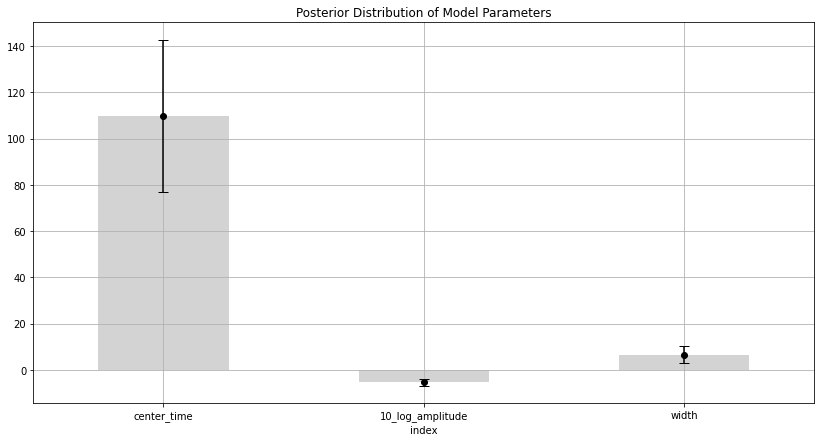

In [0]:
#@title Plot the model parameters posterior distribution
param_summary.index = ['center_time', '10_log_amplitude', 'width',
                      #  'abs_error',
                       'relative_error'][:len(param_summary.index)]
param_summary_plot = param_summary.copy() 
param_summary_plot.reset_index(drop=False, inplace=True)

err_vals = ((param_summary['hpd_2.5'] - param_summary['mean']).values,
            (param_summary['hpd_97.5'] - param_summary['mean']).values)
ax = param_summary_plot.plot(x='index', y='mean', kind='bar', figsize=(14, 7),
                 title='Posterior Distribution of Model Parameters',
                 yerr=err_vals, color='lightgrey',
                 legend=False, grid=True,
                 capsize=5)
param_summary_plot.plot(x='index', y='mean', color='k', marker='o',
                        linestyle='None', ax=ax, grid=True, legend=False,
                        xlim=plt.gca().get_xlim())

In [0]:
#@title Spaghetti plot of the posterior distribution
def plot_country_posterior(plot_title, trace, simple_model_data, num_traces=100,
                           save_plot=False):
  predict_data = simple_model_data.copy()[['DateRep', 'Deaths', target,
                                            'Population']]
  next_period_predict = predict_data.copy()
  next_period_predict['DateRep'] = predict_data['DateRep'] + datetime.timedelta(
      days=num_days)
  next_period_predict['Deaths'] = np.nan
  next_period_predict[target] = np.nan
  predict_data = pd.concat([predict_data, next_period_predict])
  days_since_start = np.arange(num_days*2)
  predict_data['Date'] = predict_data['DateRep'].astype(str)

  fig = go.Figure()

  for i in range(num_traces):
    param_center = trace[-(i+1)]['center_time']
    param_width = trace[-(i+1)]['width']
    param_log_amplitude = trace[-(i+1)]['10_log_amplitude']

    rel_distance = np.abs(days_since_start-param_center)/param_width
    rel_pred = 4*np.exp(-rel_distance)/((1+np.exp(-rel_distance))**2)
    
    predict_data['Prediction'] = rel_pred * (10**param_log_amplitude)
    if normalize_by_population:
      predict_data['Prediction'] *= predict_data['Population'] 

    fig.add_trace(go.Scatter(
        x=predict_data.Date.values,
        y=predict_data.Prediction.values,
        marker_color="grey",
        name="Predicted trace " + str(i+1),
        mode='lines',
    ))

  fig.add_trace(go.Scatter(
      x=predict_data.Date.values,
      y=predict_data.Deaths.values,
      marker_color="red",
      name="Actual deaths",
      mode='lines',
  ))

  fig.update_layout(title=plot_title, title_x=0.5,
                    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
                        text="Date",
                        font=dict(size=axis_label_font_size))),
                    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                        text="Daily deaths",
                        font=dict(size=axis_label_font_size))),
                    font=dict(size=tick_font_size))

  fig.show()

  if save_plot:
    plotly.offline.plot(
        fig, filename='forecast_plots/' + plot_title + '-traces.html')

plot_country_posterior(studied_country, country_trace, simple_model_data)

In [0]:
#@title Plot the single country predicted deaths with the actual death count
MAP_params = False #@param ["False", "True"] {type:"raw"}

def plot_country_forecast(plot_title, MAP_params, map_estimate, param_summary,
                          simple_model_data, save_plot=False):
  if MAP_params:
    param_center = map_estimate['center_time']
    param_width = map_estimate['width']
    param_log_amplitude = map_estimate['10_log_amplitude']
  else:
    param_center = param_summary['mean'][param_summary.index == 'center_time'].values[0]
    param_width = param_summary['mean'][param_summary.index == 'width'].values[0]
    param_log_amplitude = param_summary['mean'][param_summary.index == '10_log_amplitude'].values[0]

  predict_data = simple_model_data.copy()[['DateRep', 'Deaths', target,
                                          'Population']]
  next_period_predict = predict_data.copy()
  next_period_predict['DateRep'] = predict_data['DateRep'] + datetime.timedelta(
      days=num_days)
  next_period_predict['Deaths'] = np.nan
  next_period_predict[target] = np.nan
  predict_data = pd.concat([predict_data, next_period_predict])
                          
  days_since_start = np.arange(num_days*2)
  rel_distance = np.abs(days_since_start-param_center)/param_width
  rel_pred = 4*np.exp(-rel_distance)/((1+np.exp(-rel_distance))**2)
  predict_data['Date'] = predict_data['DateRep'].astype(str)
  predict_data['Prediction'] = rel_pred * (10**param_log_amplitude)
  if normalize_by_population:
    predict_data['Prediction'] *= predict_data['Population'] 

  fig = go.Figure()
  fig.add_trace(go.Scatter(
      x=predict_data.Date.values,
      y=predict_data.Prediction.values,
      name="Predicted deaths",
      mode='lines',
  ))
  fig.add_trace(go.Scatter(
      x=predict_data.Date.values,
      y=predict_data.Deaths.values,
      name="Actual deaths",
      mode='lines',
  ))

  fig.update_layout(title=plot_title, title_x=0.5,
                    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(
                        text="Date",
                        font=dict(size=axis_label_font_size))),
                    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(
                        text="Daily deaths",
                        font=dict(size=axis_label_font_size))),
                    font=dict(size=tick_font_size))
  fig.show()

  if save_plot:
    plotly.offline.plot(fig, filename='forecast_plots/' + plot_title + '.html')

plot_country_forecast(studied_country, MAP_params, map_estimate, param_summary, 
                      simple_model_data)

In [0]:
#@title Optional: generate forecasts and store the plots for all countries
download_forecast_plots = True #@param ["False", "True"] {type:"raw"}

if download_forecast_plots:
  ! rm -R forecast_plots/
  ! mkdir forecast_plots
  for i, studied_country in enumerate(
      np.unique(analysis_df[[country_col_name]].values)):
    print("Creating forecasts for country {} of {}: {}".format(
        i+1, num_countries, studied_country))
    simple_model_data = analysis_df.iloc[(
      analysis_df[[country_col_name]].values[:, 0] == studied_country)]
    with ipython_io.capture_output() as captured:
      param_summary, single_country_model, country_trace = fit_pm_model(
          simple_model_data, count_distribution="Poisson",
          normalize_by_population=True)
      map_estimate = pm.find_MAP(model=single_country_model)
    plot_country_forecast(studied_country,
                          MAP_params=False,
                          map_estimate=map_estimate,
                          param_summary=param_summary, 
                          simple_model_data=simple_model_data,
                          save_plot=True,
                          )
    

    plot_country_posterior(studied_country, country_trace, simple_model_data,
                           save_plot=True)
    
  !zip -r forecast_plots-{today_str}.zip forecast_plots/
  time.sleep(10)

Creating forecasts for country 1 of 19: Australia


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


Creating forecasts for country 2 of 19: Austria


In [0]:
if download_forecast_plots:
  files.download("forecast_plots-" + today_str + ".zip")

# Next steps
- Try multi-country initial model

# Recent additions
- Automate date of import file (now hard coded to March 19)
- Finalize single country model
- Incorporate population to reduce amplitude variance

# Maybe
- Include region population statistics so we restrict the model to regions with similar spread